### Student Performance from Game Play Using TensorFlow Decision Forests

### `Import the Required Libraries`

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_decision_forests as tfdf

### `Load the Dataset & Modify DataTypes for better performance`

* `int32 is much lighter than int64`
* `float32 is much lighter than float64`
* `Categorty datatype is much better than object datatype`

In [2]:
## Modify DataTypes of the columns
cols_dtypes={
                'elapsed_time':np.int32,
                'event_name':'category',
                'name':'category',
                'level':np.uint8,
                'room_coor_x':np.float32,
                'room_coor_y':np.float32,
                'screen_coor_x':np.float32,
                'screen_coor_y':np.float32,
                'hover_duration':np.float32,
                'text':'category',
                'fqid':'category',
                'room_fqid':'category',
                'text_fqid':'category',
                'fullscreen':'category',
                'hq':'category',
                'music':'category',
                'level_group':'category'}

df_train = pd.read_csv('/kaggle/input/predict-student-performance-from-game-play/train.csv', dtype=cols_dtypes)
print('The Shape of Training Dataset is:', df_train.shape)

The Shape of Training Dataset is: (26296946, 20)


#### `Comment: The data is composed of 20 columns and 26296946 entries.`

In [3]:
## Check the head
df_train.head()

session_id  index  elapsed_time      event_name   name  level  page  \
0  20090312431273200      0             0  cutscene_click  basic      0   NaN   
1  20090312431273200      1          1323    person_click  basic      0   NaN   
2  20090312431273200      2           831    person_click  basic      0   NaN   
3  20090312431273200      3          1147    person_click  basic      0   NaN   
4  20090312431273200      4          1863    person_click  basic      0   NaN   

   room_coor_x  room_coor_y  screen_coor_x  screen_coor_y  hover_duration  \
0  -413.991394  -159.314682          380.0          494.0             NaN   
1  -413.991394  -159.314682          380.0          494.0             NaN   
2  -413.991394  -159.314682          380.0          494.0             NaN   
3  -413.991394  -159.314682          380.0          494.0             NaN   
4  -412.991394  -159.314682          381.0          494.0             NaN   

                            text    fqid                       room_fqid  \
0                      undefined   intro  tunic.historicalsociety.closet   
1  Whatcha doing over there, Jo?  gramps  tunic.historicalsociety.closet   
2         Just talking to Teddy.  gramps  tunic.historicalsociety.closet   
3     I gotta run to my meeting!  gramps  tunic.historicalsociety.closet   
4            Can I come, Gramps?  gramps  tunic.historicalsociety.closet   

                                           text_fqid fullscreen hq music  \
0               tunic.historicalsociety.closet.intro          0  0     1   
1  tunic.historicalsociety.closet.gramps.intro_0_...          0  0     1   
2  tunic.historicalsociety.closet.gramps.intro_0_...          0  0     1   
3  tunic.historicalsociety.closet.gramps.intro_0_...          0  0     1   
4  tunic.historicalsociety.closet.gramps.intro_0_...          0  0     1   

  level_group  
0         0-4  
1         0-4  
2         0-4  
3         0-4  
4         0-4

In [4]:
## Check the Info for the dataset
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26296946 entries, 0 to 26296945
Data columns (total 20 columns):
 #   Column          Dtype   
---  ------          -----   
 0   session_id      int64   
 1   index           int64   
 2   elapsed_time    int32   
 3   event_name      category
 4   name            category
 5   level           uint8   
 6   page            float64 
 7   room_coor_x     float32 
 8   room_coor_y     float32 
 9   screen_coor_x   float32 
 10  screen_coor_y   float32 
 11  hover_duration  float32 
 12  text            category
 13  fqid            category
 14  room_fqid       category
 15  text_fqid       category
 16  fullscreen      category
 17  hq              category
 18  music           category
 19  level_group     category
dtypes: category(10), float32(5), float64(1), int32(1), int64(2), uint8(1)
memory usage: 1.5 GB


### Load the labels

* `The labels for the training dataset are stored in the **train_labels.csv**`.
* `It consists of the information on whether the user in a particular session answered each question correctly.`

In [5]:
## Load the labels file
data_labels = pd.read_csv('/kaggle/input/predict-student-performance-from-game-play/train_labels.csv')
data_labels.head()

session_id  correct
0  20090312431273200_q1        1
1  20090312433251036_q1        0
2  20090312455206810_q1        1
3  20090313091715820_q1        0
4  20090313571836404_q1        1

In [6]:
## Split the (session_id) to both the session and number of question
data_labels['session'] = data_labels['session_id'].apply(lambda x: int(x.split('_')[0]))
data_labels['question'] = data_labels['session_id'].apply(lambda x: int(x.split('_')[-1][1:]))  ## the number of question
data_labels.head()

session_id  correct            session  question
0  20090312431273200_q1        1  20090312431273200         1
1  20090312433251036_q1        0  20090312433251036         1
2  20090312455206810_q1        1  20090312455206810         1
3  20090313091715820_q1        0  20090313091715820         1
4  20090313571836404_q1        1  20090313571836404         1

#### `Our goal is to train models for each question to predict the label `correct` for any input user session.`

### `Visualization`

#### `CountPlot for correct column in all dataset`

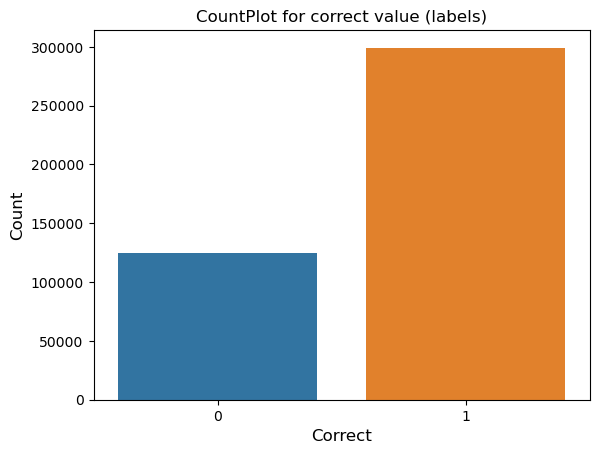

In [7]:
## CountPlot for correct column in labels
sns.countplot(x='correct', data=data_labels)
plt.title('CountPlot for correct value (labels)', fontsize=12, color='k')
plt.xlabel('Correct', fontsize=12, color='k')
plt.ylabel('Count', fontsize=12, color='k')
plt.show()

#### `plot countplot for correct column (labels) for each question`

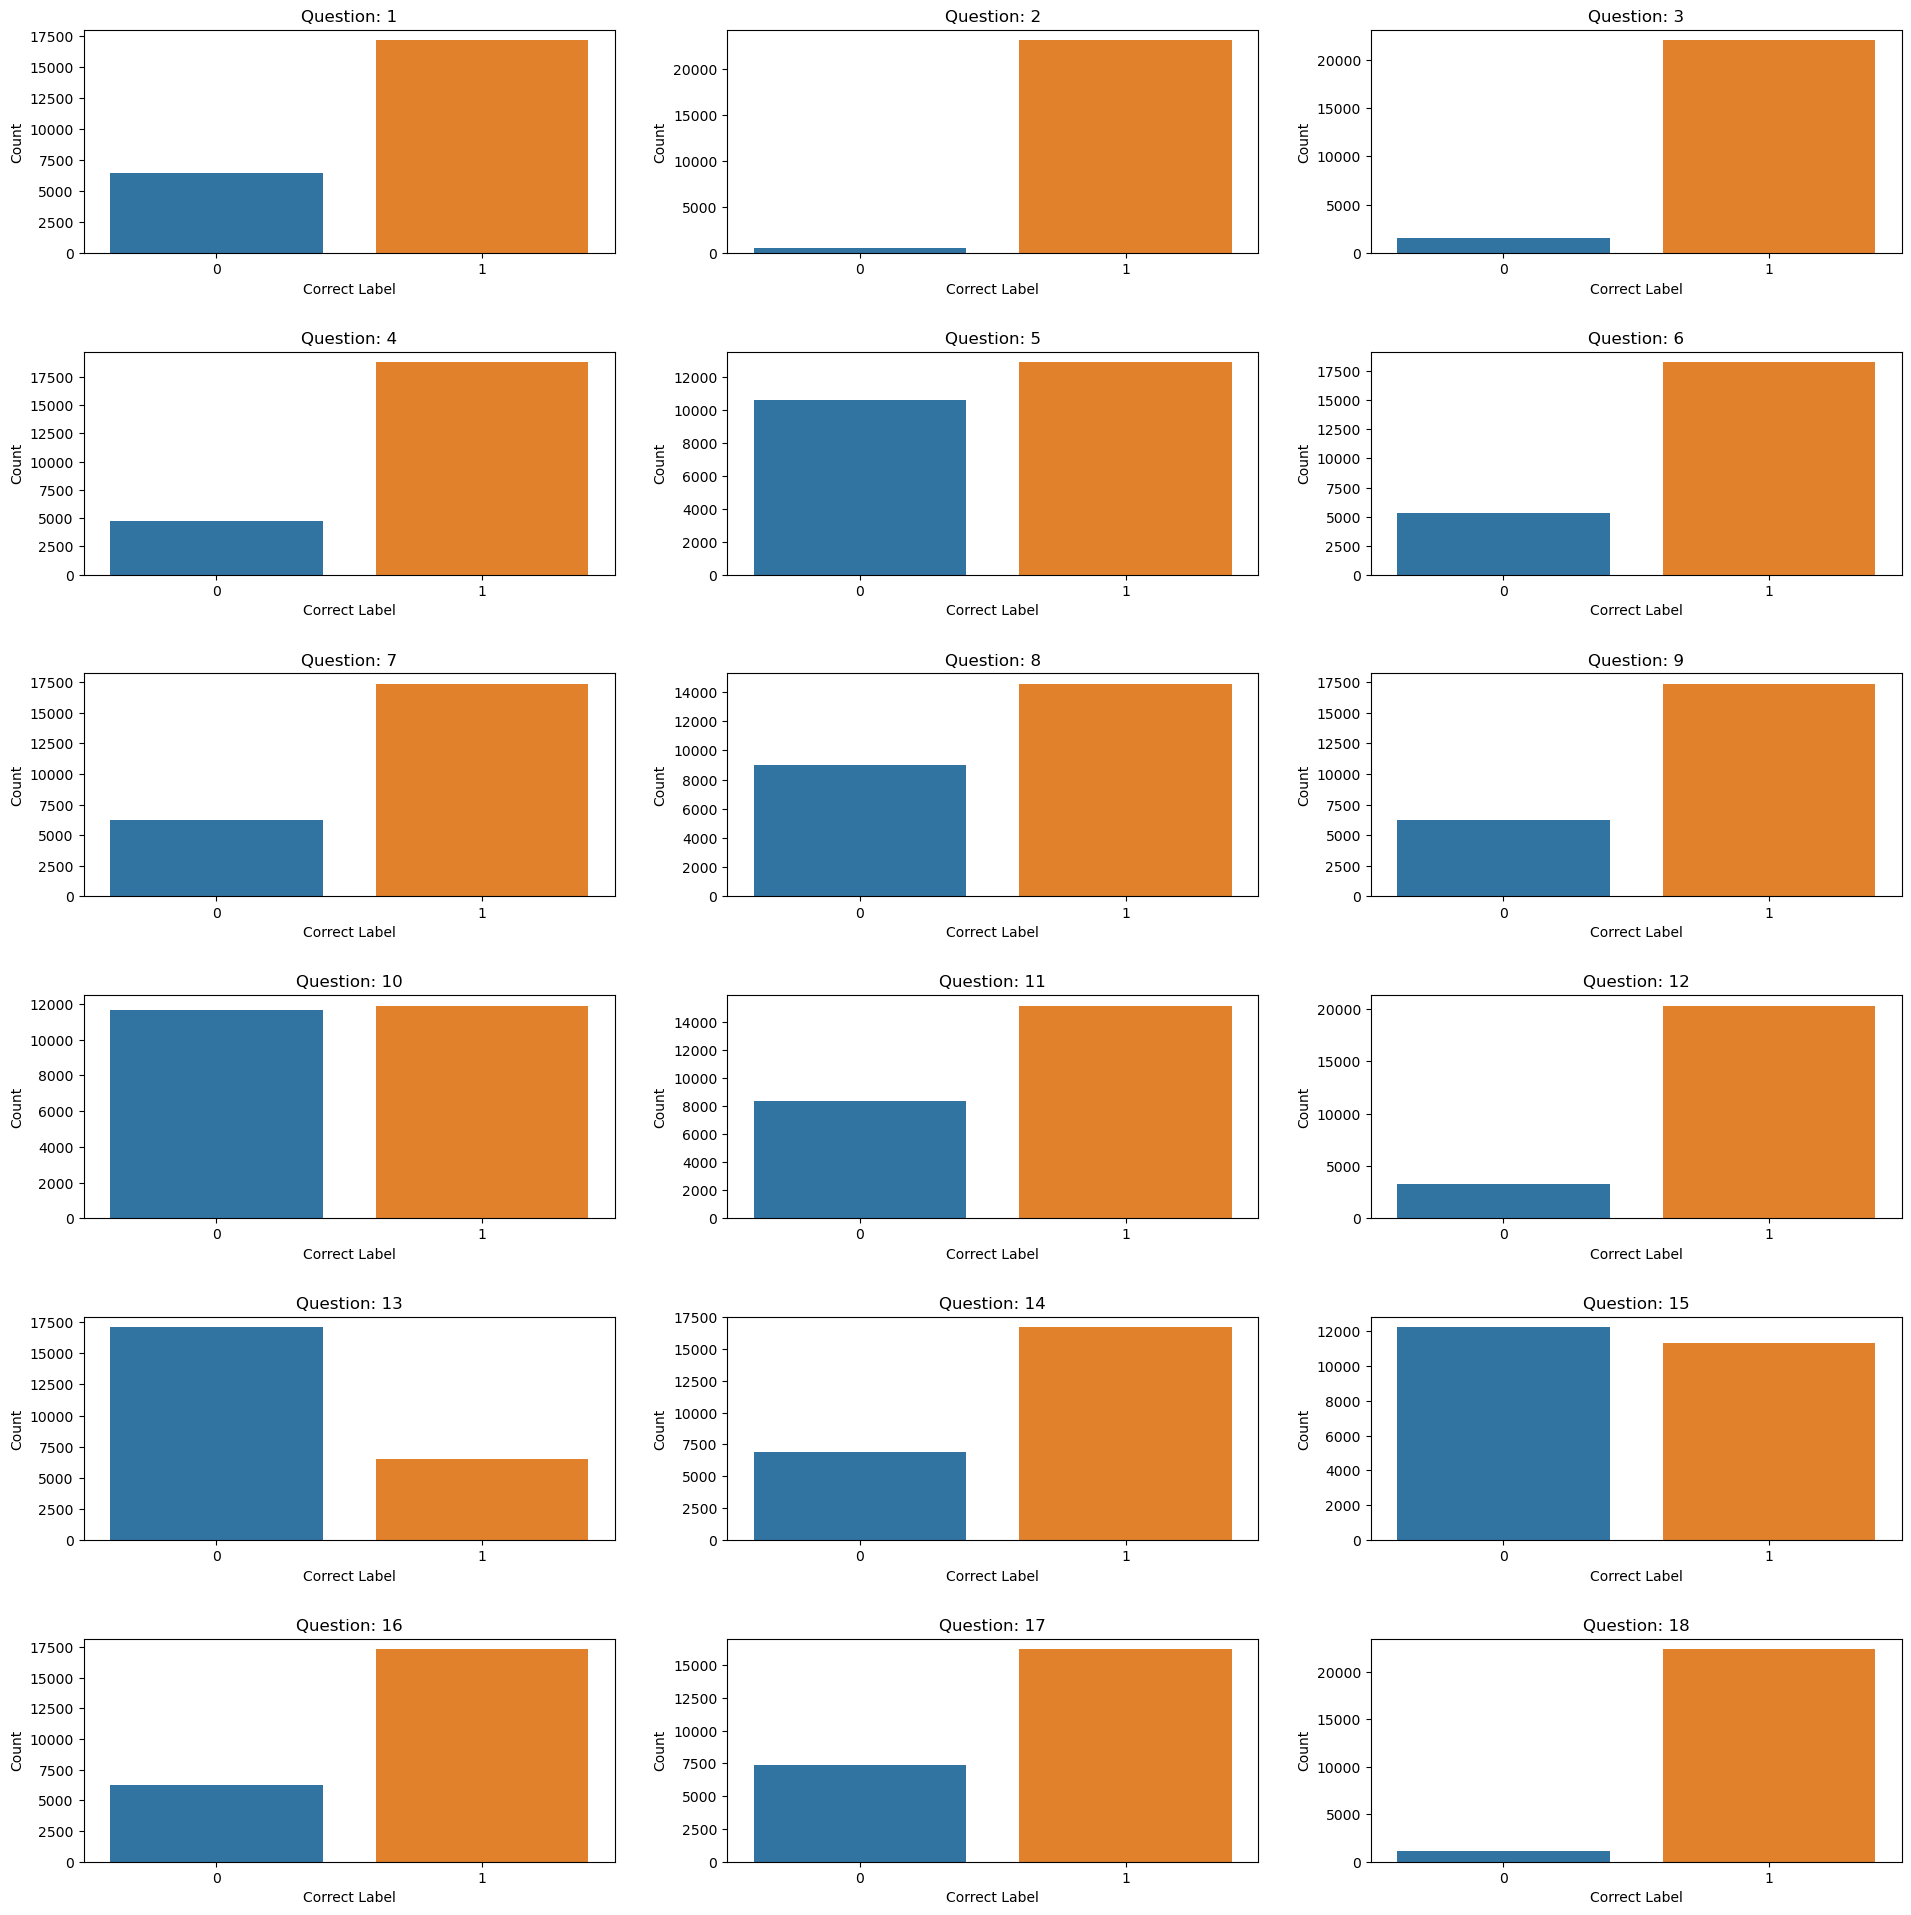

In [8]:
## plot the values of correct column (labels) for each question.
q_num = data_labels['question'].unique().reshape(6, 3)
fig, ax = plt.subplots(6, 3, figsize=(20, 20))
fig.tight_layout(pad=5)
for row in range(6):
    for col in range(3):
        plt.sca(ax[row, col])
        sns.countplot(x=data_labels[data_labels['question']==q_num[row, col]]['correct'])
        plt.xlabel('Correct Label')
        plt.ylabel('Count')
        plt.title(f'Question: {q_num[row, col]}')

### `Data Preprocessing`

As summarized in the competition overview, the dataset presents the questions and data to us in order of `levels - level segments`(represented by column `level_group`) 0-4, 5-12, and 13-22. We have to predict the correctness of each segment's questions as they are presented. To do this we will create basic aggregate features from the relevant columns. You can create more features to boost your scores. 

First, we will create two separate lists with names of the Categorical columns and Numerical columns. Taking more features

#### `Feature Engineering`

In [9]:
## Take only the features you interested in
categ_cols = ['event_name', 'name','fqid', 'room_fqid', 'text_fqid']
num_cols = ['elapsed_time','level','page','room_coor_x', 'room_coor_y', 'screen_coor_x', 'screen_coor_y', 'hover_duration']

For each categorical column, we will first group the dataset by `session_id`  and `level_group`. We will then count the number of **distinct elements** in the column for each group and store it temporarily.

For all numerical columns, we will group the dataset by `session id` and `level_group`. Instead of counting the number of distinct elements, we will calculate the `mean` and `standard deviation` of the numerical column for each group and store it temporarily.

After this, we will concatenate the temporary data frames we generated in the earlier step for each column to create our new feature engineered dataset.

In [10]:
df_train.head()

session_id  index  elapsed_time      event_name   name  level  page  \
0  20090312431273200      0             0  cutscene_click  basic      0   NaN   
1  20090312431273200      1          1323    person_click  basic      0   NaN   
2  20090312431273200      2           831    person_click  basic      0   NaN   
3  20090312431273200      3          1147    person_click  basic      0   NaN   
4  20090312431273200      4          1863    person_click  basic      0   NaN   

   room_coor_x  room_coor_y  screen_coor_x  screen_coor_y  hover_duration  \
0  -413.991394  -159.314682          380.0          494.0             NaN   
1  -413.991394  -159.314682          380.0          494.0             NaN   
2  -413.991394  -159.314682          380.0          494.0             NaN   
3  -413.991394  -159.314682          380.0          494.0             NaN   
4  -412.991394  -159.314682          381.0          494.0             NaN   

                            text    fqid                       room_fqid  \
0                      undefined   intro  tunic.historicalsociety.closet   
1  Whatcha doing over there, Jo?  gramps  tunic.historicalsociety.closet   
2         Just talking to Teddy.  gramps  tunic.historicalsociety.closet   
3     I gotta run to my meeting!  gramps  tunic.historicalsociety.closet   
4            Can I come, Gramps?  gramps  tunic.historicalsociety.closet   

                                           text_fqid fullscreen hq music  \
0               tunic.historicalsociety.closet.intro          0  0     1   
1  tunic.historicalsociety.closet.gramps.intro_0_...          0  0     1   
2  tunic.historicalsociety.closet.gramps.intro_0_...          0  0     1   
3  tunic.historicalsociety.closet.gramps.intro_0_...          0  0     1   
4  tunic.historicalsociety.closet.gramps.intro_0_...          0  0     1   

  level_group  
0         0-4  
1         0-4  
2         0-4  
3         0-4  
4         0-4

In [11]:
## Note: there are duplicaets
df_train[df_train[['session_id']].duplicated()]

session_id  index  elapsed_time      event_name       name  \
1         20090312431273200      1          1323    person_click      basic   
2         20090312431273200      2           831    person_click      basic   
3         20090312431273200      3          1147    person_click      basic   
4         20090312431273200      4          1863    person_click      basic   
5         20090312431273200      5          3423    person_click      basic   
...                     ...    ...           ...             ...        ...   
26296941  22100221145014656   1600       5483231  navigate_click  undefined   
26296942  22100221145014656   1601       5485166  navigate_click  undefined   
26296943  22100221145014656   1602       5485917  navigate_click  undefined   
26296944  22100221145014656   1603       5486753  navigate_click  undefined   
26296945  22100221145014656   1604       5487952      checkpoint      basic   

          level  page  room_coor_x  room_coor_y  screen_coor_x  screen_coor_y  \
1             0   NaN  -413.991394  -159.314682          380.0          494.0   
2             0   NaN  -413.991394  -159.314682          380.0          494.0   
3             0   NaN  -413.991394  -159.314682          380.0          494.0   
4             0   NaN  -412.991394  -159.314682          381.0          494.0   
5             0   NaN  -412.991394  -157.314682          381.0          492.0   
...         ...   ...          ...          ...            ...            ...   
26296941     22   NaN   343.887299    36.701027          483.0          273.0   
26296942     22   NaN   332.696075   141.493179          545.0          221.0   
26296943     22   NaN   369.912872   140.569199          611.0          217.0   
26296944     22   NaN   252.299652   123.805893          526.0          232.0   
26296945     22   NaN          NaN          NaN            NaN            NaN   

          hover_duration                                               text  \
1                    NaN                      Whatcha doing over there, Jo?   
2                    NaN                             Just talking to Teddy.   
3                    NaN                         I gotta run to my meeting!   
4                    NaN                                Can I come, Gramps?   
5                    NaN  Sure thing, Jo. Grab your notebook and come up...   
...                  ...                                                ...   
26296941             NaN                                                NaN   
26296942             NaN                                                NaN   
26296943             NaN                                                NaN   
26296944             NaN                                                NaN   
26296945             NaN                                                NaN   

                    fqid                       room_fqid  \
1                 gramps  tunic.historicalsociety.closet   
2                 gramps  tunic.historicalsociety.closet   
3                 gramps  tunic.historicalsociety.closet   
4                 gramps  tunic.historicalsociety.closet   
5                 gramps  tunic.historicalsociety.closet   
...                  ...                             ...   
26296941             NaN            tunic.capitol_2.hall   
26296942  chap4_finale_c            tunic.capitol_2.hall   
26296943             NaN            tunic.capitol_2.hall   
26296944  chap4_finale_c            tunic.capitol_2.hall   
26296945  chap4_finale_c            tunic.capitol_2.hall   

                                                  text_fqid fullscreen hq  \
1         tunic.historicalsociety.closet.gramps.intro_0_...          0  0   
2         tunic.historicalsociety.closet.gramps.intro_0_...          0  0   
3         tunic.historicalsociety.closet.gramps.intro_0_...          0  0   
4         tunic.historicalsociety.closet.gramps.intro_0_...          0  0   
5         tunic.historicalsociety.closet

In [12]:
## Feature Engineering Function
## For each Categorical column -- get the number of unique values in it after grouping by (session_id & level_group)
## For each Numerical column -- get mean & std after grouping by (session_id & level_group)
def feature_engineering(dataset):
    dfs = []
    for c in categ_cols:
        tmp = dataset.groupby(['session_id','level_group'])[c].agg('nunique')
        tmp.name = tmp.name + '_nunique'
        dfs.append(tmp)
    for c in num_cols:
        tmp = dataset.groupby(['session_id','level_group'])[c].agg('mean')
        dfs.append(tmp)
    for c in num_cols:
        tmp = dataset.groupby(['session_id','level_group'])[c].agg('std')
        tmp.name = tmp.name + '_std'
        dfs.append(tmp)
        
    ## Concatenate all of them finally
    dataset_df = pd.concat(dfs, axis=1)
    ## Choossing to fill NaNs by (-1)
    dataset_df = dataset_df.fillna(-1)
    dataset_df = dataset_df.reset_index()
    dataset_df = dataset_df.set_index('session_id')
    
    return dataset_df

In [13]:
## Call the function
df_train_new = feature_engineering(dataset=df_train)
print('The shape of processed Training Dataset is:', df_train_new.shape)

The shape of processed Training Dataset is: (70686, 22)


In [14]:
## Check the head of it
df_train_new.head()

level_group  event_name_nunique  name_nunique  fqid_nunique  \
session_id                                                                      
20090312431273200         0-4                  10             3            30   
20090312431273200       13-22                  10             3            49   
20090312431273200        5-12                  10             3            39   
20090312433251036         0-4                  11             4            22   
20090312433251036       13-22                  11             6            73   

                   room_fqid_nunique  text_fqid_nunique  elapsed_time  \
session_id                                                              
20090312431273200                  7                 17  8.579356e+04   
20090312431273200                 12                 35  1.040601e+06   
20090312431273200                 11                 24  3.572052e+05   
20090312433251036                  6                 11  9.763342e+04   
20090312433251036                 16                 43  2.498852e+06   

                       level  page  room_coor_x  ...  screen_coor_y  \
session_id                                       ...                  
20090312431273200   1.945455  -1.0     7.701275  ...     383.044861   
20090312431273200  17.402381  -1.0  -130.347168  ...     379.301025   
20090312431273200   8.054054  -1.0    14.306062  ...     378.784912   
20090312433251036   1.870504   0.0   -84.045959  ...     370.723083   
20090312433251036  17.762529   5.1   -30.762283  ...     387.930084   

                   hover_duration  elapsed_time_std  level_std  page_std  \
session_id                                                                 
20090312431273200     2389.500000      49246.539458   1.230975 -1.000000   
20090312431273200      899.925903     126666.129584   2.358652 -1.000000   
20090312431273200      969.333313      80175.676658   2.096919 -1.000000   
20090312433251036     1378.750000      67372.714092   1.232616  0.000000   
20090312433251036      720.384949     777382.529186   1.825923  0.863075   

                   room_coor_x_std  room_coor_y_std  screen_coor_x_std  \
session_id                                                               
20090312431273200       399.296038       129.292411         214.871000   
20090312431273200       622.061374       230.370874         240.280218   
20090312431273200       357.227701       137.409476         203.268560   
20090312433251036       445.980041       156.186242         252.554707   
20090312433251036       529.575656       234.279590         259.288856   

                   screen_coor_y_std  hover_duration_std  
session_id                                                
20090312431273200         104.082743         3227.370757  
20090312431273200          99.067861         1305.088265  
20090312431273200         120.255453         1316.408315  
20090312433251036         121.062929         2114.876406  
20090312433251036         133.345693         1990.705518  

[5 rows x 22 columns]

#### `Comment: Our feature engineered dataset is composed of 22 columns and 70686 entries. `

In [15]:
## Describe the New Dataset
df_train_new.describe()

event_name_nunique  name_nunique  fqid_nunique  room_fqid_nunique  \
count        70686.000000  70686.000000  70686.000000       70686.000000   
mean            10.390021      3.885324     40.468650          10.268908   
std              0.832923      0.799293     13.020929           2.928351   
min              7.000000      3.000000     18.000000           5.000000   
25%             10.000000      3.000000     25.000000           7.000000   
50%             11.000000      4.000000     43.000000          11.000000   
75%             11.000000      4.000000     51.000000          12.000000   
max             11.000000      6.000000     81.000000          17.000000   

       text_fqid_nunique  elapsed_time         level          page  \
count       70686.000000  7.068600e+04  70686.000000  70686.000000   
mean           23.838412  2.811806e+06      9.311221      1.439995   
std             8.989095  2.289877e+07      6.523788      2.350494   
min             8.000000  4.591262e+02      0.923372     -1.000000   
25%            15.000000  1.642777e+05      2.051613     -1.000000   
50%            23.000000  5.882137e+05      8.140526      1.000000   
75%            32.000000  1.351434e+06     17.592593      4.000000   
max            48.000000  1.191886e+09     20.222101      6.000000   

        room_coor_x   room_coor_y  ...  screen_coor_y  hover_duration  \
count  70686.000000  70686.000000  ...   70686.000000    7.068600e+04   
mean     -33.454849    -92.222832  ...     379.749146    4.119625e+03   
std       80.784378     69.349052  ...      36.971046    1.394260e+05   
min     -461.440735   -409.231293  ...     177.051849   -1.000000e+00   
25%      -90.615677   -151.717484  ...     358.117455    9.709706e+02   
50%      -20.255626    -71.538727  ...     377.843857    1.427761e+03   
75%       23.220109    -38.693486  ...     397.018394    2.158794e+03   
max      328.096100    160.347992  ...     986.192993    2.772298e+07   

       elapsed_time_std     level_std      page_std  room_coor_x_std  \
count      7.068600e+04  70686.000000  70686.000000     70686.000000   
mean       9.322398e+05      1.916549      0.038805       468.689088   
std        1.206491e+07      0.492239      0.785170       106.991644   
min        2.337003e+02      0.684670     -1.000000       261.425412   
25%        8.240024e+04      1.295298     -1.000000       381.066225   
50%        1.440869e+05      2.099711      0.000000       431.901352   
75%        2.240529e+05      2.316163      0.735893       585.347609   
max        9.946229e+08      3.580235      2.715695       817.257133   

       room_coor_y_std  screen_coor_x_std  screen_coor_y_std  \
count     70686.000000       70686.000000       70686.000000   
mean        183.186301         240.795420         124.016602   
std          48.884988          28.709135          15.844603   
min          90.098533         109.415466          68.257406   
25%         143.588600         222.569734         113.994303   
50%         162.941973         238.383832         122.388964   
75%         233.385259         255.083349         132.067430   
max         349.049304         612.958607         331.833790   

       hover_duration_std  
count        7.068600e+04  
mean         1.322598e+04  
std          4.868272e+05  
min         -1.000000e+00  
25%          1.368802e+03  
50%          2.041432e+03  
75%          3.105588e+03  
max          7.837739e+07  

[8 rows x 21 columns]

### `Check TimeSeries Distribution`
> It is a TimeSeries Distribution

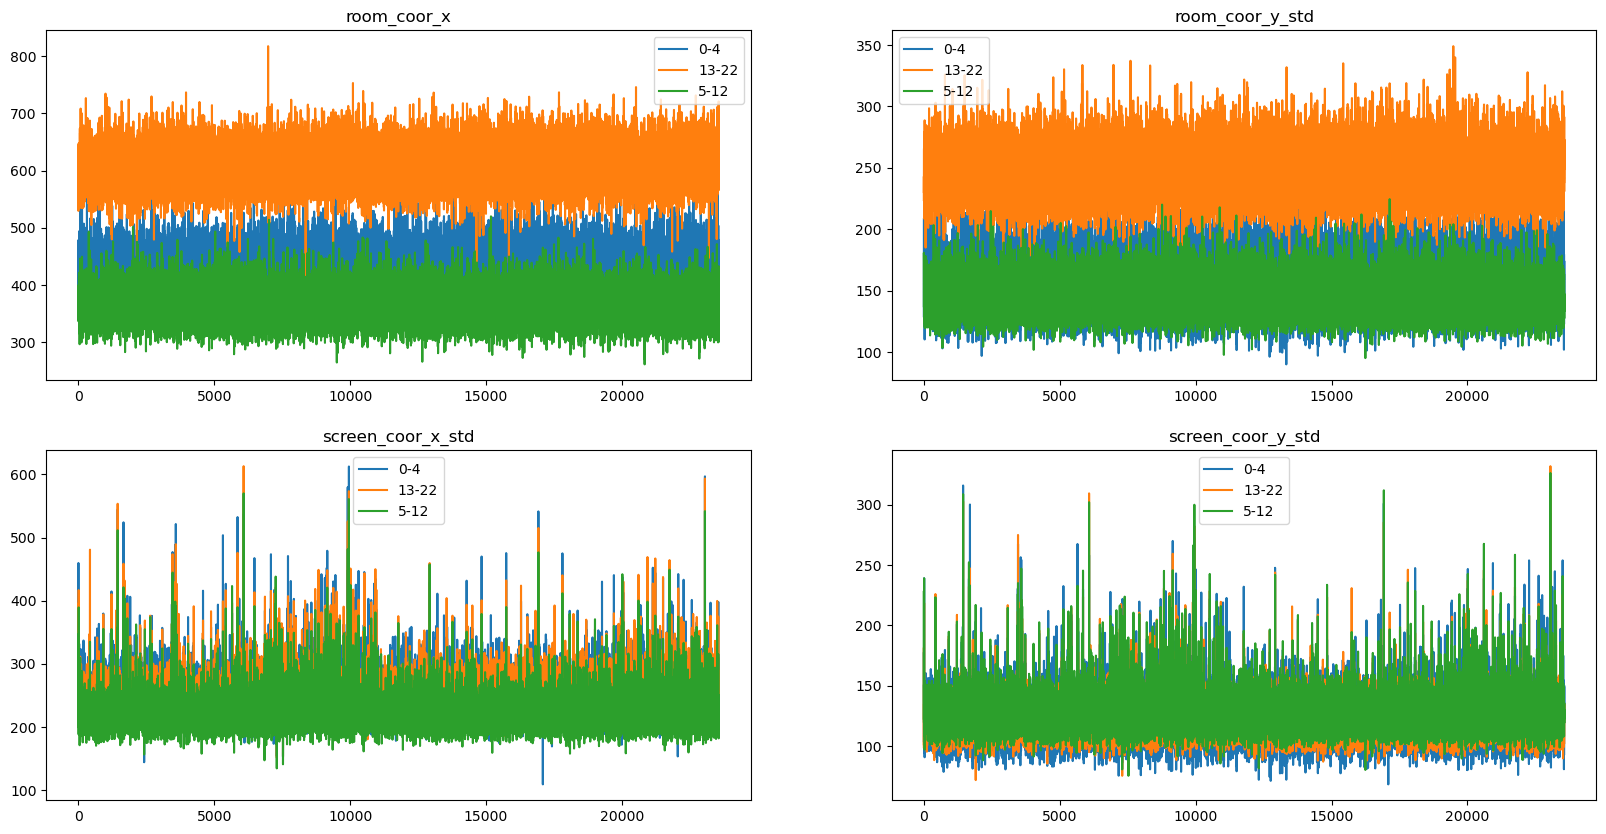

In [16]:
## TimeSeries Distributino for some Numerical Featuers after grouping (level_group)
fig, ax = plt.subplots(2, 2, figsize=(20, 10))

for col, vals in df_train_new.groupby('level_group'):
    ax[0, 0].plot(range(1, len(vals['room_coor_x_std'])+1), vals['room_coor_x_std'], label=col)
    ax[0, 0].set_title('room_coor_x')
    ax[0, 0].legend()
    ax[0, 1].plot(range(1, len(vals['room_coor_y_std'])+1), vals['room_coor_y_std'], label=col)
    ax[0, 1].set_title('room_coor_y_std')
    ax[0, 1].legend()
    ax[1, 0].plot(range(1, len(vals['screen_coor_x_std'])+1), vals['screen_coor_x_std'], label=col)
    ax[1, 0].set_title('screen_coor_x_std')
    ax[1, 0].legend()
    ax[1, 1].plot(range(1, len(vals['screen_coor_y_std'])+1), vals['screen_coor_y_std'], label=col)
    ax[1, 1].set_title('screen_coor_y_std')
    ax[1, 1].legend()

### `Split the Dataset`

In [17]:
## Unique values for session_id
unique_users = df_train_new.index.unique()
print('Unique Session_id in the Dataset \t \n', unique_users)

Unique Session_id in the Dataset 	 
 Int64Index([20090312431273200, 20090312433251036, 20090312455206810,
            20090313091715820, 20090313571836404, 20090314035813970,
            20090314121766812, 20090314221187252, 20090314363702160,
            20090314441803444,
            ...
            22100213081672770, 22100213133089136, 22100215032067016,
            22100215190998610, 22100215241104530, 22100215342220508,
            22100215460321130, 22100217104993650, 22100219442786200,
            22100221145014656],
           dtype='int64', name='session_id', length=23562)


In [18]:
## Take the unique values of (session_id: index)

## 90% for Training, 10% for Validation
unique_users = df_train_new.index.unique()
cutoff = int(len(unique_users) * 0.8)

## Take first 80% of unique session_id for Train --- Then slice these session_id from the whold dataset (of course there are duplicated session_id)\
X_train = df_train_new.loc[unique_users[:cutoff]]

## Take last 20% of unique session_id for Valid --- Then slice these session_id from the whold dataset (of course there are duplicated session_id)\
X_valid = df_train_new.loc[unique_users[cutoff:]]

print('The Shape of Full Training Dataset is:', df_train_new.shape)
print('The Shape of Training Dataset is:', X_train.shape)
print('The Shape of Validatino Dataset is:', X_valid.shape)

The Shape of Full Training Dataset is: (70686, 22)
The Shape of Training Dataset is: (56547, 22)
The Shape of Validatino Dataset is: (14139, 22)


### `Model`

In [19]:
## Using TensorFlow for Decision Forest (light Models)
tfdf.keras.get_all_models()

[tensorflow_decision_forests.keras.RandomForestModel,
 tensorflow_decision_forests.keras.GradientBoostedTreesModel,
 tensorflow_decision_forests.keras.CartModel,
 tensorflow_decision_forests.keras.DistributedGradientBoostedTreesModel]

### `RandomForest Model`

* `I will train a model for each question to predict if the question will be answered correctly by a user.` 
* `There are a total of 18 questions in the dataset. Hence, we will be training 18 models, one for each question.`

In [20]:
## I want to make a prediction DataFrame for each session_id
## So, I make an empty dataframe indexed by session_id
users_list_valid = X_valid.index.unique()
data = np.zeros((len(users_list_valid), 18))
df_prediction = pd.DataFrame(data, index=users_list_valid)
df_prediction.head()

0    1    2    3    4    5    6    7    8    9    10   11  \
session_id                                                                      
22000320020067784  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
22000321083750010  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
22000401381351532  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
22000407142860316  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
22000407572357990  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

                    12   13   14   15   16   17  
session_id                                       
22000320020067784  0.0  0.0  0.0  0.0  0.0  0.0  
22000321083750010  0.0  0.0  0.0  0.0  0.0  0.0  
22000401381351532  0.0  0.0  0.0  0.0  0.0  0.0  
22000407142860316  0.0  0.0  0.0  0.0  0.0  0.0  
22000407572357990  0.0  0.0  0.0  0.0  0.0  0.0

#### `Note: I will create a Model for each question`

In [21]:
## Create an empty dictionary to store the models created for each question.
models = {}

## Create an empty dictionary to store the evaluation score for each question.
evaluation_valid ={}

Before training the data we have to understand how `level_groups` and `questions` are associated to each other.

In this game the first quiz checkpoint(i.e., questions 1 to 3) comes after finishing levels 0 to 4. So for training questions 1 to 3 we will use data from the `level_group` 0-4. Similarly, we will use data from the `level_group` 5-12 to train questions from 4 to 13 and data from the `level_group` 13-22 to train questions from 14 to 18.

We will train a model for each question and store the trained model in the `models` dict.

In [22]:
data_labels.head()

session_id  correct            session  question
0  20090312431273200_q1        1  20090312431273200         1
1  20090312433251036_q1        0  20090312433251036         1
2  20090312455206810_q1        1  20090312455206810         1
3  20090313091715820_q1        0  20090313091715820         1
4  20090313571836404_q1        1  20090313571836404         1

In [23]:
# Iterate through questions 1 to 18 to train models for each question, evaluate
# the trained model and store the predicted values.
for q_no in range(1,19):

    ## Select level group for the question based on the q_no.
    if q_no <= 3: 
        grp = '0-4'
    elif q_no <=13 : 
        grp = '5-12'
    elif q_no <= 22: 
        grp = '13-22'
    print(f"Question Number: {q_no} & Group: {grp}")
    
        
    # Filter the rows in the datasets based on the selected level group. 
    train_df = X_train.loc[X_train['level_group'] == grp]
    train_users = train_df.index.values
    valid_df = X_valid.loc[X_valid['level_group'] == grp]
    valid_users = valid_df.index.values

    # Select the labels for the related q_no.
    train_labels = data_labels.loc[data_labels['question']==q_no].set_index('session').loc[train_users]
    valid_labels = data_labels.loc[data_labels['question']==q_no].set_index('session').loc[valid_users]

    # Add the label to the filtered datasets.
    train_df["correct"] = train_labels["correct"]
    valid_df["correct"] = valid_labels["correct"]

    ## We need to convert the datatset from Pandas format (pd.DataFrame) to TensorFlow
    train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_df.loc[:, train_df.columns != 'level_group'], label="correct")
    valid_ds = tfdf.keras.pd_dataframe_to_tf_dataset(valid_df.loc[:, valid_df.columns != 'level_group'], label="correct")

    ## Create and compile the model
    rfm = tfdf.keras.RandomForestModel(verbose=0)
    rfm.compile(metrics=["accuracy"])

    # Train the model.
    rfm.fit(x=train_ds)

    # Store the model
    models[f'{grp}_{q_no}'] = rfm

    ## Evaluate the trained model on the validation dataset
    inspector = rfm.make_inspector()
    inspector.evaluation()
    evaluation = rfm.evaluate(x=valid_ds, return_dict=True)
    evaluation_valid[q_no] = evaluation["accuracy"]         

    ## store the predicted values in the `df_prediction` dataframe.
    predict = rfm.predict(x=valid_ds)
    df_prediction.loc[valid_users, q_no-1] = predict.flatten()     

Question Number: 1 & Group: 0-4


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
[INFO 2023-04-29T09:32:19.714786833+00:00 kernel.cc:1214] Loading model from path /tmp/tmpy161h9ys/model/ with prefix 3b55d256b64e454a
[INFO 2023-04-29T09:32:22.205131803+00:00 decision_forest.cc:661] Model loaded with 300 root(s), 574200 node(s), and 21 input feature(s).
[INFO 2023-04-29T09:3

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
5/5 [==============================] - 0s 63ms/step
Question Number: 2 & Group: 0-4


[INFO 2023-04-29T09:32:38.503251582+00:00 kernel.cc:1214] Loading model from path /tmp/tmp8uocfa3r/model/ with prefix 0bd95b9f999f4ab6
[INFO 2023-04-29T09:32:39.161835439+00:00 decision_forest.cc:661] Model loaded with 300 root(s), 163518 node(s), and 21 input feature(s).
[INFO 2023-04-29T09:32:39.161901065+00:00 abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 2023-04-29T09:32:39.161930873+00:00 kernel.cc:1046] Use fast generic engine


5/5 [==============================] - 0s 39ms/step
Question Number: 3 & Group: 0-4


[INFO 2023-04-29T09:33:03.24576516+00:00 kernel.cc:1214] Loading model from path /tmp/tmpgf8ag21w/model/ with prefix b5286959d0a146d5
[INFO 2023-04-29T09:33:04.537083935+00:00 decision_forest.cc:661] Model loaded with 300 root(s), 316886 node(s), and 21 input feature(s).
[INFO 2023-04-29T09:33:04.537257367+00:00 abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 2023-04-29T09:33:04.537302822+00:00 kernel.cc:1046] Use fast generic engine


5/5 [==============================] - 0s 46ms/step
Question Number: 4 & Group: 5-12


[INFO 2023-04-29T09:33:23.022564603+00:00 kernel.cc:1214] Loading model from path /tmp/tmps16n0x8i/model/ with prefix 1d562c41760b426b
[INFO 2023-04-29T09:33:25.493564795+00:00 decision_forest.cc:661] Model loaded with 300 root(s), 594838 node(s), and 21 input feature(s).
[INFO 2023-04-29T09:33:25.493648136+00:00 abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 2023-04-29T09:33:25.493677434+00:00 kernel.cc:1046] Use fast generic engine


5/5 [==============================] - 0s 59ms/step
Question Number: 5 & Group: 5-12


[INFO 2023-04-29T09:33:44.771474489+00:00 kernel.cc:1214] Loading model from path /tmp/tmprfu3zbyh/model/ with prefix 54885ea3a97c41cb
[INFO 2023-04-29T09:33:47.597491553+00:00 decision_forest.cc:661] Model loaded with 300 root(s), 685578 node(s), and 21 input feature(s).
[INFO 2023-04-29T09:33:47.597562299+00:00 abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 2023-04-29T09:33:47.597592563+00:00 kernel.cc:1046] Use fast generic engine


5/5 [==============================] - 0s 63ms/step
Question Number: 6 & Group: 5-12


[INFO 2023-04-29T09:34:26.908587099+00:00 kernel.cc:1214] Loading model from path /tmp/tmpq_huhphi/model/ with prefix 26c860decd1a4fa0
[INFO 2023-04-29T09:34:29.367980867+00:00 decision_forest.cc:661] Model loaded with 300 root(s), 598264 node(s), and 21 input feature(s).
[INFO 2023-04-29T09:34:29.368077264+00:00 abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 2023-04-29T09:34:29.368123211+00:00 kernel.cc:1046] Use fast generic engine


5/5 [==============================] - 0s 55ms/step
Question Number: 7 & Group: 5-12


[INFO 2023-04-29T09:34:48.653818093+00:00 kernel.cc:1214] Loading model from path /tmp/tmp765a8v_4/model/ with prefix 42a28988d6264b0d
[INFO 2023-04-29T09:34:51.249432547+00:00 decision_forest.cc:661] Model loaded with 300 root(s), 628790 node(s), and 21 input feature(s).
[INFO 2023-04-29T09:34:51.249499581+00:00 abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 2023-04-29T09:34:51.249529787+00:00 kernel.cc:1046] Use fast generic engine


5/5 [==============================] - 0s 55ms/step
Question Number: 8 & Group: 5-12


[INFO 2023-04-29T09:35:10.684022007+00:00 kernel.cc:1214] Loading model from path /tmp/tmpzqvsv1up/model/ with prefix afb360e330cf49fa
[INFO 2023-04-29T09:35:12.850269109+00:00 decision_forest.cc:661] Model loaded with 300 root(s), 521344 node(s), and 21 input feature(s).
[INFO 2023-04-29T09:35:12.850384921+00:00 abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 2023-04-29T09:35:12.850414997+00:00 kernel.cc:1046] Use fast generic engine


5/5 [==============================] - 0s 60ms/step
Question Number: 9 & Group: 5-12


[INFO 2023-04-29T09:35:33.208183595+00:00 kernel.cc:1214] Loading model from path /tmp/tmpnb4ywsxh/model/ with prefix e8cdc172a6454550
[INFO 2023-04-29T09:35:35.612904577+00:00 decision_forest.cc:661] Model loaded with 300 root(s), 591760 node(s), and 21 input feature(s).
[INFO 2023-04-29T09:35:35.613081645+00:00 abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 2023-04-29T09:35:35.613127499+00:00 kernel.cc:1046] Use fast generic engine


5/5 [==============================] - 0s 55ms/step
Question Number: 10 & Group: 5-12


[INFO 2023-04-29T09:35:55.213524592+00:00 kernel.cc:1214] Loading model from path /tmp/tmpm9wr22l2/model/ with prefix 5e8857619184451e
[INFO 2023-04-29T09:35:57.820111119+00:00 decision_forest.cc:661] Model loaded with 300 root(s), 627318 node(s), and 21 input feature(s).
[INFO 2023-04-29T09:35:57.820170913+00:00 abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 2023-04-29T09:35:57.820200722+00:00 kernel.cc:1046] Use fast generic engine


5/5 [==============================] - 0s 59ms/step
Question Number: 11 & Group: 5-12


[INFO 2023-04-29T09:36:17.042896354+00:00 kernel.cc:1214] Loading model from path /tmp/tmp2f7f8ith/model/ with prefix 1b557011bb724e8a
[INFO 2023-04-29T09:36:19.289032913+00:00 decision_forest.cc:661] Model loaded with 300 root(s), 549588 node(s), and 21 input feature(s).
[INFO 2023-04-29T09:36:19.28924849+00:00 abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 2023-04-29T09:36:19.289298487+00:00 kernel.cc:1046] Use fast generic engine


5/5 [==============================] - 0s 63ms/step
Question Number: 12 & Group: 5-12


[INFO 2023-04-29T09:36:38.625106291+00:00 kernel.cc:1214] Loading model from path /tmp/tmpgo3mgk07/model/ with prefix e859e737c3624834
[INFO 2023-04-29T09:36:40.461881822+00:00 decision_forest.cc:661] Model loaded with 300 root(s), 445510 node(s), and 21 input feature(s).
[INFO 2023-04-29T09:36:40.461945294+00:00 abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 2023-04-29T09:36:40.461978196+00:00 kernel.cc:1046] Use fast generic engine


5/5 [==============================] - 0s 51ms/step
Question Number: 13 & Group: 5-12


[INFO 2023-04-29T09:37:01.995974934+00:00 kernel.cc:1214] Loading model from path /tmp/tmpatb9vjxh/model/ with prefix a8664f33ce894a05
[INFO 2023-04-29T09:37:04.273331353+00:00 decision_forest.cc:661] Model loaded with 300 root(s), 559316 node(s), and 21 input feature(s).
[INFO 2023-04-29T09:37:04.273393903+00:00 abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 2023-04-29T09:37:04.273422927+00:00 kernel.cc:1046] Use fast generic engine


5/5 [==============================] - 0s 60ms/step
Question Number: 14 & Group: 13-22


[INFO 2023-04-29T09:37:44.73756564+00:00 kernel.cc:1214] Loading model from path /tmp/tmpbybpv_5n/model/ with prefix ef3c338a81f34c60
[INFO 2023-04-29T09:37:47.380640712+00:00 decision_forest.cc:661] Model loaded with 300 root(s), 637996 node(s), and 21 input feature(s).
[INFO 2023-04-29T09:37:47.380701894+00:00 abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 2023-04-29T09:37:47.380732671+00:00 kernel.cc:1046] Use fast generic engine


5/5 [==============================] - 0s 58ms/step
Question Number: 15 & Group: 13-22


[INFO 2023-04-29T09:38:26.173158719+00:00 kernel.cc:1214] Loading model from path /tmp/tmpj3mwmsa6/model/ with prefix b07c220ec039407d
[INFO 2023-04-29T09:38:28.992921697+00:00 decision_forest.cc:661] Model loaded with 300 root(s), 680744 node(s), and 21 input feature(s).
[INFO 2023-04-29T09:38:28.992989213+00:00 abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 2023-04-29T09:38:28.993028307+00:00 kernel.cc:1046] Use fast generic engine


5/5 [==============================] - 0s 70ms/step
Question Number: 16 & Group: 13-22


[INFO 2023-04-29T09:39:07.363974858+00:00 kernel.cc:1214] Loading model from path /tmp/tmp6inm64hq/model/ with prefix 6696ea9090fc4667
[INFO 2023-04-29T09:39:08.938249129+00:00 decision_forest.cc:661] Model loaded with 300 root(s), 390266 node(s), and 21 input feature(s).
[INFO 2023-04-29T09:39:08.938455695+00:00 abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 2023-04-29T09:39:08.938500393+00:00 kernel.cc:1046] Use fast generic engine


5/5 [==============================] - 0s 46ms/step
Question Number: 17 & Group: 13-22


[INFO 2023-04-29T09:39:29.973624307+00:00 kernel.cc:1214] Loading model from path /tmp/tmp0t_7vg7k/model/ with prefix 4394a1916eec40a1
[INFO 2023-04-29T09:39:31.974582024+00:00 decision_forest.cc:661] Model loaded with 300 root(s), 490460 node(s), and 21 input feature(s).
[INFO 2023-04-29T09:39:31.974825006+00:00 abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 2023-04-29T09:39:31.97500869+00:00 kernel.cc:1046] Use fast generic engine


5/5 [==============================] - 0s 51ms/step
Question Number: 18 & Group: 13-22


[INFO 2023-04-29T09:39:47.433289481+00:00 kernel.cc:1214] Loading model from path /tmp/tmpbj21e3gp/model/ with prefix ea2848c209914957
[INFO 2023-04-29T09:39:48.590980703+00:00 decision_forest.cc:661] Model loaded with 300 root(s), 287188 node(s), and 21 input feature(s).
[INFO 2023-04-29T09:39:48.591066066+00:00 abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 2023-04-29T09:39:48.591109222+00:00 kernel.cc:1046] Use fast generic engine


5/5 [==============================] - 0s 42ms/step


In [24]:
## Create and compile the model
rfm = tfdf.keras.RandomForestModel(verbose=0)
rfm.compile(metrics=["accuracy"])

### `Inspect the Accuracy of the models.`

We trained a model for each question. Now let us check the accuracy of each model and overall accuracy for all the models combined. 

Note: Since the label distribution is imbalanced, we can't make an assumption on the model performance from accuracy score alone. 

In [25]:
## Check the Accuracy for each question, and overall accuracy
for name, value in evaluation_valid.items():
  print(f"question {name}: accuracy {value:.4f}")
print('***'*30)
print("Average accuracy: \t", sum(evaluation_valid.values())/18)

question 1: accuracy 0.7331
question 2: accuracy 0.9756
question 3: accuracy 0.9351
question 4: accuracy 0.7952
question 5: accuracy 0.6281
question 6: accuracy 0.7882
question 7: accuracy 0.7462
question 8: accuracy 0.6395
question 9: accuracy 0.7679
question 10: accuracy 0.5986
question 11: accuracy 0.6582
question 12: accuracy 0.8699
question 13: accuracy 0.7197
question 14: accuracy 0.7335
question 15: accuracy 0.6109
question 16: accuracy 0.7488
question 17: accuracy 0.7036
question 18: accuracy 0.9516
******************************************************************************************
Average accuracy: 	 0.7557583020793067


### `Visualize the model`

One benefit of tree-based models is that we can easily visualize them. The default number of trees used in the Random Forests is 300. 

Let us pick one model from `models` dict and select a tree to display below.

In [26]:
## Choose on of the Models
## Let us take the 2nd of (0-4 | the level-group)
tfdf.model_plotter.plot_model_in_colab(models['0-4_2'], tree_idx=0, max_depth=3)

### `Features Importances`

In [27]:
## Get the Feature Importance from the Model
inspector = models['0-4_2'].make_inspector()

print(f"Available Features Importances:")
for importance in inspector.variable_importances().keys():  
    print("\t", importance)

Available Features Importances:
	 NUM_AS_ROOT
	 SUM_SCORE
	 INV_MEAN_MIN_DEPTH
	 NUM_NODES


`Usually, we care with (NUM_AS_ROOT), Number of each feature splitted with in the Model`

In [28]:
## Each line is: (feature name, (index of the feature), importance score)
inspector.variable_importances()["NUM_AS_ROOT"]

[("hover_duration_std" (1; #6), 65.0),
 ("hover_duration" (1; #5), 52.0),
 ("elapsed_time_std" (1; #2), 34.0),
 ("level" (1; #7), 34.0),
 ("text_fqid_nunique" (1; #21), 23.0),
 ("elapsed_time" (1; #1), 20.0),
 ("room_coor_x_std" (1; #13), 15.0),
 ("room_fqid_nunique" (1; #16), 15.0),
 ("fqid_nunique" (1; #4), 14.0),
 ("level_std" (1; #8), 9.0),
 ("page_std" (1; #11), 4.0),
 ("name_nunique" (1; #9), 3.0),
 ("page" (1; #10), 3.0),
 ("screen_coor_y_std" (1; #20), 3.0),
 ("room_coor_y_std" (1; #15), 2.0),
 ("screen_coor_x_std" (1; #18), 2.0),
 ("room_coor_x" (1; #12), 1.0),
 ("room_coor_y" (1; #14), 1.0)]

### `Threshold-Moving for Imbalanced Classification`
>Try to get the best threshold

In [29]:
## The Defualt threshold is (0.5)
## Try that for this Notebook
true_df = pd.DataFrame(data=np.zeros((len(users_list_valid),18)), index=users_list_valid)
for i in range(18):
    # Get the true labels.
    tmp = data_labels.loc[data_labels.question == i+1].set_index('session').loc[users_list_valid]
    true_df[i] = tmp.correct.values

max_score = 0
best_threshold = 0

# Loop through threshold values from 0.4 to 0.8 and select the threshold with 
# the highest `F1 score`.
for threshold in np.arange(0.4, 0.8, 0.01):
    metric = tfa.metrics.F1Score(num_classes=2,average="macro",threshold=threshold)
    y_true = tf.one_hot(true_df.values.reshape((-1)), depth=2)
    y_pred = tf.one_hot((df_prediction.values.reshape((-1))>threshold).astype('int'), depth=2)
    metric.update_state(y_true, y_pred)
    f1_score = metric.result().numpy()
    if f1_score > max_score:
        max_score = f1_score
        best_threshold = threshold
        
print("Best threshold ", best_threshold, "\tF1 score ", max_score)

Best threshold  0.7100000000000003 	F1 score  0.67396307


### `Submission`

In [30]:
## Submission
import jo_wilder
env = jo_wilder.make_env()
iter_test = env.iter_test()

limits = {'0-4':(1, 4), '5-12':(4, 14), '13-22':(14, 19)}

for (test, sample_submission) in iter_test:
    test_df = feature_engineering(test)
    grp = test_df.level_group.values[0]
    a,b = limits[grp]
    for t in range(a,b):
        rfm = models[f'{grp}_{t}']
        test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_df.loc[:, test_df.columns != 'level_group'])
        predictions = rfm.predict(test_ds)
        mask = sample_submission.session_id.str.contains(f'q{t}')
        n_predictions = (predictions > best_threshold).astype(int)
        sample_submission.loc[mask,'correct'] = n_predictions.flatten()
    
    env.predict(sample_submission)

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.
1/1 [==============================] - 0s 71ms/step


In [31]:
! head submission.csv

session_id,correct
20090109393214576_q1,1
20090109393214576_q2,1
20090109393214576_q3,1
20090109393214576_q4,1
20090109393214576_q5,0
20090109393214576_q6,1
20090109393214576_q7,1
20090109393214576_q8,1
20090109393214576_q9,1
